

Initialization

In [1]:
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          transform= transforms.ToTensor())


100%|██████████| 9912422/9912422 [00:00<00:00, 80847432.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 121378450.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45304060.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20774840.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Utilities
These functions provide Learning curve plots and learning progress reports

In [2]:
'''Learning Curve Plot Utility'''
def plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
  fig, axs = plt.subplots(1, 2, figsize=(11,5))

  ax = axs[0]
  ax.set_title("Model Loss", fontsize=12)
  ax.plot(train_loss_history, label="Training")
  ax.plot(val_loss_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Average loss", fontsize=12)
  ax.legend(loc="best",         fontsize=12)

  ax = axs[1]
  ax.set_title("Model Accuracy", fontsize=12)
  ax.plot(train_acc_history, label="Training")
  ax.plot(val_acc_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Accuracy",     fontsize=12)
  ax.set_ylim(0,1)
  ax.legend(loc="best",         fontsize=12)

In [3]:
'''Learning progress utility'''
def log_progress(running_loss, curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}]. Running Loss: {} Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(running_loss, 2), round(progress * 100, 2))
    print(log)

In [4]:
#  preserntation for a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


<h3> Hyperparameters </h3>

In [5]:
# Hyperparameters
num_epochs = 6
num_classes = 10
batch_size = 100
learning_rate = 0.0001

<h3> Data Loader</h3>

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Model P2


Discussion:

The first change we do is add 3rd layer in the model. The third layer uses Convolution using 3x3 kernel with RelU Activation function. It also uses Batch Normalization and Max pooling with padding and stride of 2. The 2nd iteration is increase in the number of neurons in fully connected layer to 256 and another fully connected layer. Finally the third iteration is to add drop out of 0.25 to avoid overfitting on the training data set.

 #### Iteration 1: Here we add just a third layer to the network with a kernel size of 3x3 for convolution and Relu as the activation function

In [7]:
# Model
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Added third layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(3 * 3 * 64, num_classes)  # Adjusted the linear layer input size

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the model
model = ConvNet(num_classes).to(device)

#### Iteration 2: Here we increase the no, of neurons in fully connected layer to 256 and a fully connected layer

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(3 * 3 * 64, 256)  # Increased the number of neurons in the fully connected layer
        self.fc2 = nn.Linear(256, num_classes)  # Added a second fully connected layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = nn.functional.relu(self.fc(out))  # Used F.relu for the activation function
        out = self.fc2(out)
        return out

# Instantiate the model
model1 = ConvNet(num_classes).to(device)

#### Iteration 3: Here we finally add a dropout of 0.25 to avoid overfitting on the training dataset

In [9]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(3 * 3 * 64, 256)
        self.dropout = nn.Dropout(0.25)  # Added dropout layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = nn.functional.relu(self.fc(out))
        out = self.dropout(out)  # Applied dropout after the first fully connected layer
        out = self.fc2(out)
        return out

# Instantiate the model
model2 = ConvNet(num_classes).to(device)

#### Old model in the tutorial

In [10]:
# Model
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model_old = ConvNet(num_classes).to(device)

#### Training on the old model

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_old.parameters(), lr=learning_rate)

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):

    # Place network in training mode
    model_old.train()

    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(train_loader):
        # [inputs] and [labels] is one batch of images and their classes
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_old(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics for this batch
        curr_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        curr_images = labels.cpu().data.numpy().size
        curr_correct = torch.sum(preds == labels.data.reshape(-1))

        # Update running statistics for this epoch
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

    # Update statistics for epoch
    train_loss_history[epoch] = curr_loss #running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
        round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )

    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    model_old.eval()

    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Propagate batch through network
        outputs  = model_old(inputs)
        loss     = criterion(outputs, labels.squeeze())
        _, preds = torch.max(outputs, 1)

        # Update statistics for this batch
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.cpu().data.numpy().size

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)

    # Update statistics for validation data
    val_loss_history[epoch] = loss.item() #running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))

print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

EPOCH [1/6]. Running Loss: 216.73 Progress: 33.33 % 
EPOCH [1/6]. Running Loss: 277.4 Progress: 66.67 % 
EPOCH [1/6]. Running Loss: 312.1 Progress: 100.0 % 
Train Avg. Loss: [0.235] Acc: 0.8914 on 60000.0 images
Validating...
Val Avg. Loss: [0.1473] Acc: 0.9701 on 10000.0 images

EPOCH [2/6]. Running Loss: 23.29 Progress: 33.33 % 
EPOCH [2/6]. Running Loss: 40.53 Progress: 66.67 % 
EPOCH [2/6]. Running Loss: 55.42 Progress: 100.0 % 
Train Avg. Loss: [0.1773] Acc: 0.9724 on 60000.0 images
Validating...
Val Avg. Loss: [0.0335] Acc: 0.982 on 10000.0 images

EPOCH [3/6]. Running Loss: 12.13 Progress: 33.33 % 
EPOCH [3/6]. Running Loss: 24.77 Progress: 66.67 % 
EPOCH [3/6]. Running Loss: 36.14 Progress: 100.0 % 
Train Avg. Loss: [0.0343] Acc: 0.9817 on 60000.0 images
Validating...
Val Avg. Loss: [0.0256] Acc: 0.9841 on 10000.0 images

EPOCH [4/6]. Running Loss: 9.39 Progress: 33.33 % 
EPOCH [4/6]. Running Loss: 18.84 Progress: 66.67 % 
EPOCH [4/6]. Running Loss: 28.73 Progress: 100.0 % 
Tra

# Training on Iteraqtion 1

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):

    # Place network in training mode
    model.train()

    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(train_loader):
        # [inputs] and [labels] is one batch of images and their classes
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics for this batch
        curr_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        curr_images = labels.cpu().data.numpy().size
        curr_correct = torch.sum(preds == labels.data.reshape(-1))

        # Update running statistics for this epoch
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

    # Update statistics for epoch
    train_loss_history[epoch] = curr_loss #running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
        round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )

    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    model.eval()

    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Propagate batch through network
        outputs  = model(inputs)
        loss     = criterion(outputs, labels.squeeze())
        _, preds = torch.max(outputs, 1)

        # Update statistics for this batch
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.cpu().data.numpy().size

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)

    # Update statistics for validation data
    val_loss_history[epoch] = loss.item() #running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))

print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

EPOCH [1/6]. Running Loss: 15.23 Progress: 33.33 % 
EPOCH [1/6]. Running Loss: 26.92 Progress: 66.67 % 
EPOCH [1/6]. Running Loss: 36.32 Progress: 100.0 % 
Train Avg. Loss: [0.0345] Acc: 0.9881 on 60000.0 images
Validating...
Val Avg. Loss: [0.0256] Acc: 0.988 on 10000.0 images

EPOCH [2/6]. Running Loss: 8.32 Progress: 33.33 % 
EPOCH [2/6]. Running Loss: 16.17 Progress: 66.67 % 
EPOCH [2/6]. Running Loss: 24.01 Progress: 100.0 % 
Train Avg. Loss: [0.0289] Acc: 0.9901 on 60000.0 images
Validating...
Val Avg. Loss: [0.0161] Acc: 0.9893 on 10000.0 images

EPOCH [3/6]. Running Loss: 6.47 Progress: 33.33 % 
EPOCH [3/6]. Running Loss: 12.98 Progress: 66.67 % 
EPOCH [3/6]. Running Loss: 19.24 Progress: 100.0 % 
Train Avg. Loss: [0.0438] Acc: 0.9924 on 60000.0 images
Validating...
Val Avg. Loss: [0.0146] Acc: 0.9906 on 10000.0 images

EPOCH [4/6]. Running Loss: 5.23 Progress: 33.33 % 
EPOCH [4/6]. Running Loss: 10.75 Progress: 66.67 % 
EPOCH [4/6]. Running Loss: 16.09 Progress: 100.0 % 
Train

# Training on iteration 2

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):

    # Place network in training mode
    model1.train()

    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(train_loader):
        # [inputs] and [labels] is one batch of images and their classes
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics for this batch
        curr_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        curr_images = labels.cpu().data.numpy().size
        curr_correct = torch.sum(preds == labels.data.reshape(-1))

        # Update running statistics for this epoch
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

    # Update statistics for epoch
    train_loss_history[epoch] = curr_loss #running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
        round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )

    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    model1.eval()

    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Propagate batch through network
        outputs  = model1(inputs)
        loss     = criterion(outputs, labels.squeeze())
        _, preds = torch.max(outputs, 1)

        # Update statistics for this batch
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.cpu().data.numpy().size

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)

    # Update statistics for validation data
    val_loss_history[epoch] = loss.item() #running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))

print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

EPOCH [1/6]. Running Loss: 173.25 Progress: 33.33 % 
EPOCH [1/6]. Running Loss: 206.83 Progress: 66.67 % 
EPOCH [1/6]. Running Loss: 229.61 Progress: 100.0 % 
Train Avg. Loss: [0.1586] Acc: 0.9217 on 60000.0 images
Validating...
Val Avg. Loss: [0.089] Acc: 0.9768 on 10000.0 images

EPOCH [2/6]. Running Loss: 16.69 Progress: 33.33 % 
EPOCH [2/6]. Running Loss: 30.35 Progress: 66.67 % 
EPOCH [2/6]. Running Loss: 42.97 Progress: 100.0 % 
Train Avg. Loss: [0.0738] Acc: 0.9796 on 60000.0 images
Validating...
Val Avg. Loss: [0.0478] Acc: 0.9838 on 10000.0 images

EPOCH [3/6]. Running Loss: 10.44 Progress: 33.33 % 
EPOCH [3/6]. Running Loss: 20.06 Progress: 66.67 % 
EPOCH [3/6]. Running Loss: 29.08 Progress: 100.0 % 
Train Avg. Loss: [0.051] Acc: 0.9861 on 60000.0 images
Validating...
Val Avg. Loss: [0.0204] Acc: 0.9884 on 10000.0 images

EPOCH [4/6]. Running Loss: 7.68 Progress: 33.33 % 
EPOCH [4/6]. Running Loss: 15.37 Progress: 66.67 % 
EPOCH [4/6]. Running Loss: 22.12 Progress: 100.0 % 
T

# Training on iteration 3

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):

    # Place network in training mode
    model2.train()

    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(train_loader):
        # [inputs] and [labels] is one batch of images and their classes
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics for this batch
        curr_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        curr_images = labels.cpu().data.numpy().size
        curr_correct = torch.sum(preds == labels.data.reshape(-1))

        # Update running statistics for this epoch
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

    # Update statistics for epoch
    train_loss_history[epoch] = curr_loss #running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
        round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )

    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    model2.eval()

    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Propagate batch through network
        outputs  = model2(inputs)
        loss     = criterion(outputs, labels.squeeze())
        _, preds = torch.max(outputs, 1)

        # Update statistics for this batch
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.cpu().data.numpy().size

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)

    # Update statistics for validation data
    val_loss_history[epoch] = loss.item() #running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))

print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

EPOCH [1/6]. Running Loss: 184.94 Progress: 33.33 % 
EPOCH [1/6]. Running Loss: 223.48 Progress: 66.67 % 
EPOCH [1/6]. Running Loss: 248.56 Progress: 100.0 % 
Train Avg. Loss: [0.0805] Acc: 0.9037 on 60000.0 images
Validating...
Val Avg. Loss: [0.1407] Acc: 0.9739 on 10000.0 images

EPOCH [2/6]. Running Loss: 18.99 Progress: 33.33 % 
EPOCH [2/6]. Running Loss: 35.77 Progress: 66.67 % 
EPOCH [2/6]. Running Loss: 50.35 Progress: 100.0 % 
Train Avg. Loss: [0.03] Acc: 0.9758 on 60000.0 images
Validating...
Val Avg. Loss: [0.0504] Acc: 0.9855 on 10000.0 images

EPOCH [3/6]. Running Loss: 12.24 Progress: 33.33 % 
EPOCH [3/6]. Running Loss: 24.06 Progress: 66.67 % 
EPOCH [3/6]. Running Loss: 34.38 Progress: 100.0 % 
Train Avg. Loss: [0.0134] Acc: 0.9837 on 60000.0 images
Validating...
Val Avg. Loss: [0.0408] Acc: 0.9871 on 10000.0 images

EPOCH [4/6]. Running Loss: 9.01 Progress: 33.33 % 
EPOCH [4/6]. Running Loss: 18.65 Progress: 66.67 % 
EPOCH [4/6]. Running Loss: 26.88 Progress: 100.0 % 
T

## Learning curve plots

Testing on model trained with iteration 3


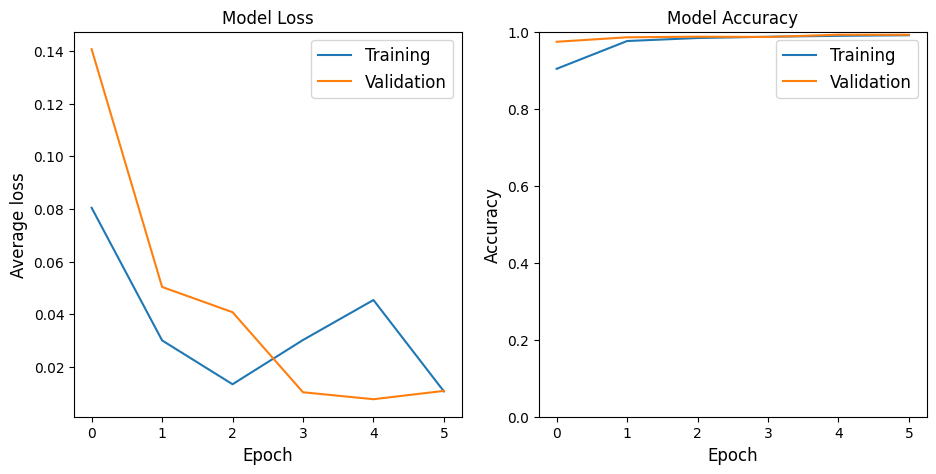

In [15]:
print('Testing on model trained with iteration 3')
plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history)


### Testing on original model

### Testing on final iteration

In [16]:
# Test the model
start_time = datetime.now()
ytest = []
rtest = np.ones((0,10))
model2.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        ytest = np.append(ytest, labels)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        outputs1 = outputs.cpu()
        rtest = np.append(rtest, outputs1, axis=0)
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

Test Accuracy of the model on the 10000 test images: 99.21 %
Time Elapsed: 1.135699 seconds


Confusion matrix, without normalization


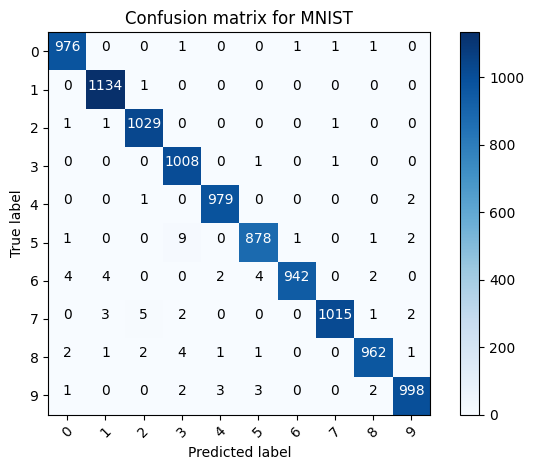

In [17]:
cfm = confusion_matrix(ytest, np.argmax (rtest,axis=1))
plot_confusion_matrix(cfm, classes=range(10),
                      title='Confusion matrix for MNIST')

In [18]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')